# import

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import scipy.io as sio
import os
import pickle

%load_ext autoreload
%autoreload 2

In [2]:
local_flag = False
if local_flag:
    repo_dir = r'D:\repo\inter_data\inter'.replace("\\", "/") # under env dimred
else:
    repo_dir = r'C:\Users\ll357\Documents\inter'.replace("\\", "/")
os.chdir(repo_dir)
from src import adp

# load grat1

ncell: 56, nstim: 1, ntrial: 219, nframe: 267
trace_cell_avg: (267,).         trace_stim_avg list len: 1.         trace_stim_avg[0].shape: (267,)


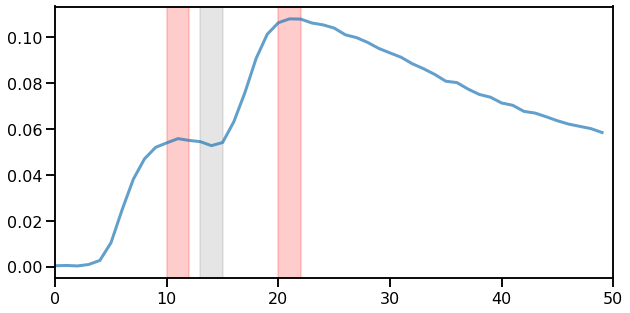

In [3]:
dir_data = r'\\duhs-user-nc1.dhe.duke.edu\dusom_glickfeldlab\All_Staff\home\lan\Data\2P_images\mat_inter\V1_i1372_220714_cellpose'
stim_id, trace_by_trial = adp.load_trace_trial_data(dir_data, vis_filter=False)
stim_id = stim_id[:trace_by_trial.shape[1]] # truncate to uncorrupted trials
trace_avg_cell, trace_cell_sem, trace_stim_avg = adp.calc_trace_stim(trace_by_trial, stim_id)

fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(trace_avg_cell[:50], alpha=0.7, linewidth=3)
ax.axvspan(10, 12, alpha=0.2, color='red')
ax.axvspan(13, 15, alpha=0.2, color='gray')
ax.axvspan(20, 22, alpha=0.2, color='red')
plt.xlim(0, 50);

# adp stability with trial filter

In [4]:
trial_filter_file = [f for f in os.listdir(dir_data) if f.__contains__('003')]
print('only taking trial filter from session 003 in V1_i1372_220714_cellpose, bc session 002 is fully corrupted')

trial_ok = np.array([])
for file in trial_filter_file:
    trial_filter = sio.loadmat(os.path.join(dir_data, file))
    trial_eye_ok = trial_filter['trial_eye_ok']
    trial_eye_ok = np.array([i[0] for i in trial_eye_ok], dtype=bool)
    trial_speed_ok = trial_filter['trial_speed_ok']
    trial_speed_ok = np.array([i[0] for i in trial_speed_ok], dtype=bool)
    trial_ok_sess = trial_eye_ok & trial_speed_ok
    trial_ok_sess = trial_ok_sess[:-1] # remove the last trial, which is not a full trial
    trial_ok = np.append(trial_ok, trial_ok_sess)

trial_ok = np.array(trial_ok, dtype=bool)
trial_ok_truncated = trial_ok[:trace_by_trial.shape[1]] # truncate trial filter to uncorrupted trials
print(f'number of trials: {len(trial_ok_truncated)}, number of good trials: {sum(trial_ok_truncated)}')

## only using good trials
stim_id = np.array(stim_id)
stim_id = stim_id[trial_ok_truncated]
trace_by_trial = trace_by_trial[:, trial_ok_truncated, :]
trace_by_trial.shape, stim_id.__len__()

only taking trial filter from session 003 in V1_i1372_220714_cellpose, bc session 002 is fully corrupted
number of trials: 219, number of good trials: 178


((56, 178, 267), 178)

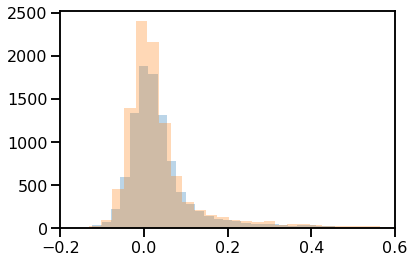

In [5]:
# get resp_ad and resp_tg [cell x trial]
base1 = trace_by_trial[:,:,0:2+1].mean(axis=2) # avg over time window frames
resp_ad = trace_by_trial[:,:,10:12+1].mean(axis=2)
resp_ad = resp_ad - base1

base2 = trace_by_trial[:,:,13:15+1].mean(axis=2)
resp_tg = trace_by_trial[:,:,20:22+1].mean(axis=2)
resp_tg = resp_tg - base2

plt.hist(resp_ad.ravel(), bins=100, alpha=0.3, label='AD');
plt.hist(resp_tg.ravel(), bins=100, alpha=0.3, label='TG');
plt.xlim(-0.2, 0.6);

## pop adp stability
population of 56 cells need 10-20 trials to get a stable adaptation value  
regardless of using mean or median to aggregate  
but using median gets abs larger adp value than mean

In [6]:
mean_or_median = np.median # for population, median is better than mean

resp_ad_pop = mean_or_median(resp_ad, axis=0) # population response as avg or median of all cells for each trial
resp_tg_pop = mean_or_median(resp_tg, axis=0)

adp_norm_diff = (resp_tg_pop - resp_ad_pop) / (resp_ad_pop + 1e-7) # difference over baseline
adp_IOU = (resp_tg_pop - resp_ad_pop) / (resp_tg_pop + resp_ad_pop + 1e-7) # difference over sum
adp_norm_diff.shape, mean_or_median(adp_norm_diff), mean_or_median(adp_IOU) # group_size = 1, use all cell resp mean or median

((178,), -0.3277956473623085, -0.10998034675422219)

In [7]:
# shuffle resp_ad_pop and resp_tg_pop the same way
np.random.seed(42)
idx = np.random.permutation(resp_ad_pop.shape[0])
resp_ad_pop_shuf = resp_ad_pop[idx]
resp_tg_pop_shuf = resp_tg_pop[idx]

# for whole population, loop thru trial numbers to group together to get a stable adaptation value  
adp_agg = []
adp_std = []
for group_size in np.arange(1, trace_by_trial.shape[1] // 2):
    ngroup = trace_by_trial.shape[1] // group_size

    resp_ad_cut = resp_ad_pop_shuf[:group_size*ngroup].reshape(ngroup, group_size) # reshape to ngroup x group_size
    resp_tg_cut = resp_tg_pop_shuf[:group_size*ngroup].reshape(ngroup, group_size)
    resp_ad_group = mean_or_median(resp_ad_cut, axis=1) # aggregate resp within group of trials
    resp_tg_group = mean_or_median(resp_tg_cut, axis=1)

    adp_group = (resp_tg_group - resp_ad_group) / (resp_ad_group + 1e-7) # calc adp with `avg resp within group`
    adp_group_agg = mean_or_median(adp_group) # agg adp across group
    adp_group_std = np.std(adp_group) # std of adp across group
    adp_agg.append(adp_group_agg) # group_size variable, all cell resp agg
    adp_std.append(adp_group_std)

adp_agg = np.array(adp_agg)
adp_std = np.array(adp_std)
adp_sem = adp_std / np.sqrt(adp_std.shape[0])

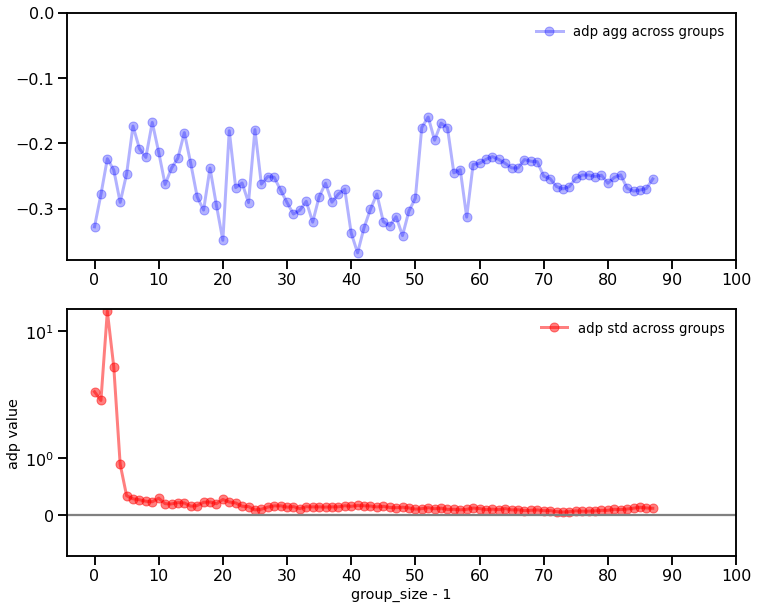

In [8]:
plt.figure(figsize=(12, 10))
plt.subplot(2,1,1)
plt.plot(adp_agg, 'o-', color='b', linewidth=3, alpha=0.3, label='adp agg across groups')
# plt.axhline(-0.32, color='g')
plt.xticks(np.arange(0,110,10))
plt.ylim(plt.ylim()[0], 0)
plt.legend(frameon=False);

plt.subplot(2,1,2)
plt.plot(adp_std, 'o-', color='r', linewidth=3, alpha=0.5, label='adp std across groups')
plt.axhline(0, color='gray')
plt.xticks(np.arange(0,110,10))
plt.xlabel('group_size - 1')
# plt.ylim(0, 0.5)
plt.ylabel('adp value')
plt.gca().set_yscale('symlog')
plt.legend(frameon=False);

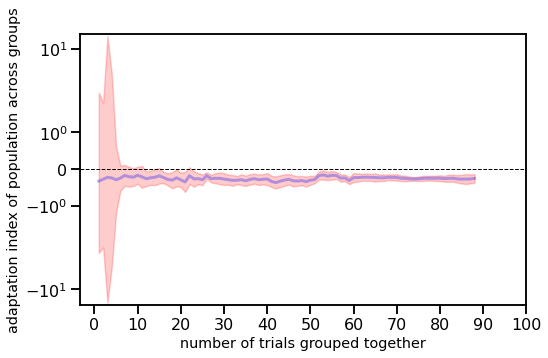

In [9]:
errbar = adp_std # adp_sem 
x = np.arange(1, adp_agg.shape[0]+1)

fig = plt.figure(figsize=(8, 5))
plt.plot(x, adp_agg, '-', color='b', linewidth=3, alpha=0.3)
plt.fill_between(x, 
                 adp_agg + errbar, adp_agg - errbar, 
                 color='r', alpha=0.2)
plt.axhline(0, color='k', linewidth=1, linestyle='--')

plt.xticks(np.arange(0,110,10))
plt.xlabel('number of trials grouped together')
plt.gca().set_yscale('symlog')
plt.ylabel('adaptation index of population across groups'); #  across groups of different sizes

## single cell adp stability
single cells need 20-30 trials to get a stable adaptation value  

In [10]:
mean_or_median = np.median # for single cell, median is better than mean too

ncell = trace_by_trial.shape[0]
ngroup_min = 2
nsize = len(np.arange(1, trace_by_trial.shape[1] // ngroup_min)) # how many group_size to test
adp_cell_agg = np.zeros((ncell, nsize))
adp_cell_std = np.zeros((ncell, nsize))
adp_cell_sem = np.zeros((ncell, nsize))

for icell in np.arange(ncell):
    resp_ad_cell = resp_ad[icell, :]
    resp_tg_cell = resp_tg[icell, :]

    # shuffle resp_ad_pop and resp_tg_pop the same way
    np.random.seed(42)
    idx = np.random.permutation(resp_ad_pop.shape[0])
    resp_ad_cell_shuf = resp_ad_cell[idx]
    resp_tg_cell_shuf = resp_tg_cell[idx]

    for isize, group_size in enumerate(np.arange(1, trace_by_trial.shape[1] // ngroup_min)):
        ngroup = trace_by_trial.shape[1] // group_size

        resp_ad_cut = resp_ad_cell_shuf[:group_size*ngroup].reshape(ngroup, group_size)
        resp_tg_cut = resp_tg_cell_shuf[:group_size*ngroup].reshape(ngroup, group_size)
        resp_ad_group = np.sum(resp_ad_cut, axis=1)
        resp_tg_group = np.sum(resp_tg_cut, axis=1)

        adp_group = (resp_tg_group - resp_ad_group) / (resp_ad_group + 1e-7)
        adp_group_agg = mean_or_median(adp_group)
        adp_group_std = np.std(adp_group)
        adp_group_sem = adp_group_std / np.sqrt(adp_group.shape[0])
        adp_cell_agg[icell, isize] = adp_group_agg
        adp_cell_std[icell, isize] = adp_group_std
        adp_cell_sem[icell, isize] = adp_group_sem

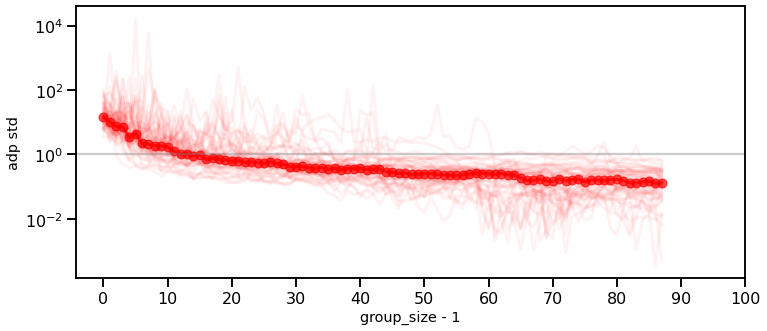

In [11]:
adp_cell_std_agg = mean_or_median(adp_cell_std, axis=0)

plt.figure(figsize=(12, 5))
plt.plot(adp_cell_std_agg, 'o-', color='r', linewidth=3, alpha=0.7, label='adp std across groups, agg over cells')
for icell in np.arange(ncell):
    plt.plot(adp_cell_std[icell, :], '-', color='r', linewidth=3, alpha=0.05, label='adp std across groups')

plt.axhline(1, alpha=0.4, color='gray')
plt.xticks(np.arange(0,110,10))
plt.xlabel('group_size - 1')

# plt.ylim(1e-3, plt.ylim()[1]) # set y axis lower limit
# plt.ylim(1e-2, 1e2)
plt.yscale('log')
plt.ylabel('adp std');

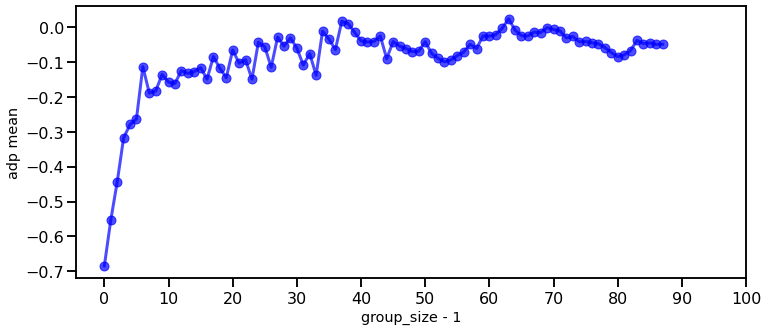

In [12]:
adp_cell_agg_agg = mean_or_median(adp_cell_agg, axis=0)

plt.figure(figsize=(12, 5))
plt.plot(adp_cell_agg_agg, 'o-', color='b', linewidth=3, alpha=0.7, label='adp agg across groups, agg over cells')
# for icell in np.arange(ncell):
#     plt.plot(adp_cell_agg[icell, :], '-', color='b', linewidth=3, alpha=0.05, label='adp agg across groups')

plt.xticks(np.arange(0,110,10))
plt.xlabel('group_size - 1')

# plt.yscale('symlog') # plot negative values on -log scale, plot ~0 values linearly: https://stackoverflow.com/questions/3305865/what-is-the-difference-between-log-and-symlog
# plt.ylim(-0.5,1)
plt.ylabel('adp mean');

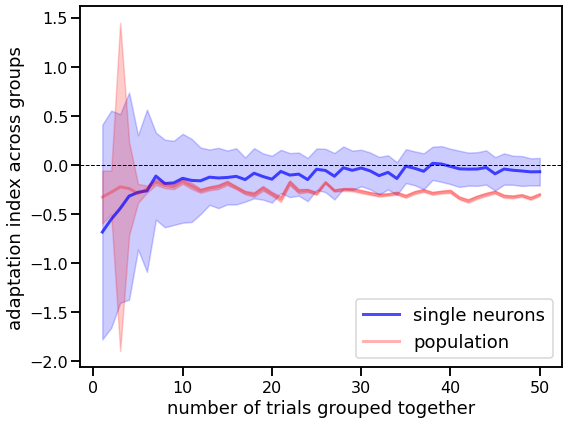

<Figure size 432x288 with 0 Axes>

In [13]:
adp_cell_sem_agg = mean_or_median(adp_cell_sem, axis=0) # adp error between groups -> agg across cells
errbar = adp_cell_sem_agg
x = np.arange(1, adp_agg.shape[0]+1)
xlim = 50

fig = plt.figure(figsize=(8, 6))
plt.plot(x[:xlim], adp_cell_agg_agg[:xlim], '-', color='blue', linewidth=3, alpha=0.7, label='single neurons')
plt.fill_between(x[:xlim],  
                adp_cell_agg_agg[:xlim] + errbar[:xlim], adp_cell_agg_agg[:xlim] - errbar[:xlim], color='b', alpha=0.2)

errbar = adp_sem 
# x = np.arange(1, adp_agg.shape[0]+1)
plt.plot(x[:xlim], adp_agg[:xlim], '-', color='red', linewidth=3, alpha=0.3, label='population')
plt.fill_between(x[:xlim], 
                 adp_agg[:xlim] + errbar[:xlim], adp_agg[:xlim] - errbar[:xlim], 
                 color='r', alpha=0.2)

plt.axhline(0, color='k', linewidth=1, linestyle='--')

plt.xticks(np.arange(0, xlim+1, 10))
plt.xlabel('number of trials grouped together', fontsize=18)
plt.ylabel('adaptation index across groups', fontsize=18)
plt.legend(fontsize=18, loc='lower right');

plt.tight_layout()
plt.show()
plt.draw()
# figpath = r'C:\Users\ll357\Documents\inter\results\poster 2022/'.replace('\\', '/')
# fig.savefig(os.path.join(figpath, 'adp_stability_group_trials.pdf'), format='pdf')

# adp stability without trial filter
but with subsampling to match ntrial

In [14]:
stim_id, trace_by_trial = adp.load_trace_trial_data(dir_data, vis_filter=False)
stim_id = stim_id[:trace_by_trial.shape[1]] # truncate to uncorrupted trials
trace_by_trial.shape, stim_id.__len__()

ncell: 56, nstim: 1, ntrial: 219, nframe: 267


((56, 219, 267), 219)

In [15]:
ntrial_filtered = trial_ok_truncated.sum() # number of trials after filtering and discarding corrupted trials

ntrial_bad = sum(trial_ok_truncated == False) # make sure to contain itrials where trial_ok_truncated==False
ntrial_random = ntrial_filtered - ntrial_bad
print('ntrial_bad: %d, ntrial_random: %d' % (ntrial_bad, ntrial_random))
print('we will use all bad trials, and subsample from good trials. sum should be ntrial_filtered')

trial_id_arr = np.arange(len(trial_ok_truncated))
trial_id_arr = np.random.choice(trial_id_arr[trial_ok_truncated], size=ntrial_random, replace=False) # among where trial_ok_truncated==True, randomly subsample
trial_id_arr = np.concatenate((trial_id_arr, np.where(trial_ok_truncated == False)[0])) # concatenate with where trial_ok_truncated==False

assert len(set(trial_id_arr)) == ntrial_filtered
trial_subsample = np.zeros(len(trial_ok_truncated), dtype=bool)
trial_subsample[trial_id_arr] = True # convert to boolean array just like trial_ok_truncated
# trial_ok_truncated.shape, trial_subsample.shape, trial_id_arr.shape

## only using subsampled trials
stim_id = np.array(stim_id)
stim_id = stim_id[trial_subsample]
trace_by_trial = trace_by_trial[:, trial_subsample, :]
trace_by_trial.shape, stim_id.__len__()

ntrial_bad: 41, ntrial_random: 137
we will use all bad trials, and subsample from good trials. sum should be ntrial_filtered


((56, 178, 267), 178)

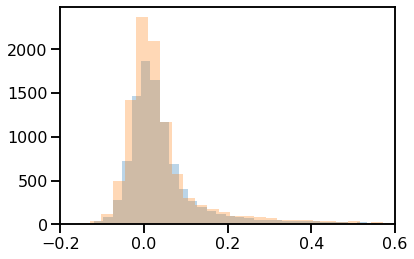

In [16]:
# get resp_ad and resp_tg [cell x trial]
base1 = trace_by_trial[:,:,0:2+1].mean(axis=2) # avg over time window frames
resp_ad = trace_by_trial[:,:,10:12+1].mean(axis=2)
resp_ad = resp_ad - base1

base2 = trace_by_trial[:,:,13:15+1].mean(axis=2)
resp_tg = trace_by_trial[:,:,20:22+1].mean(axis=2)
resp_tg = resp_tg - base2

plt.hist(resp_ad.ravel(), bins=100, alpha=0.3, label='AD');
plt.hist(resp_tg.ravel(), bins=100, alpha=0.3, label='TG');
plt.xlim(-0.2, 0.6);

## pop adp stability
population of 56 cells need 10-20 trials to get a stable adaptation value  
regardless of using mean or median to aggregate  
but using median gets abs larger adp value than mean

In [17]:
mean_or_median = np.median # for population, median is better than mean

resp_ad_pop = mean_or_median(resp_ad, axis=0) # population response as avg or median of all cells for each trial
resp_tg_pop = mean_or_median(resp_tg, axis=0)

adp_norm_diff = (resp_tg_pop - resp_ad_pop) / (resp_ad_pop + 1e-7) # difference over baseline
adp_IOU = (resp_tg_pop - resp_ad_pop) / (resp_tg_pop + resp_ad_pop + 1e-7) # difference over sum
adp_norm_diff.shape, mean_or_median(adp_norm_diff), mean_or_median(adp_IOU) # group_size = 1, use all cell resp mean or median

((178,), -0.25485231340724235, -0.12181104950934625)

In [18]:
# shuffle resp_ad_pop and resp_tg_pop the same way
np.random.seed(42)
idx = np.random.permutation(resp_ad_pop.shape[0])
resp_ad_pop_shuf = resp_ad_pop[idx]
resp_tg_pop_shuf = resp_tg_pop[idx]

# for whole population, loop thru trial numbers to group together to get a stable adaptation value  
adp_agg = []
adp_std = []
for group_size in np.arange(1, trace_by_trial.shape[1] // 2):
    ngroup = trace_by_trial.shape[1] // group_size

    resp_ad_cut = resp_ad_pop_shuf[:group_size*ngroup].reshape(ngroup, group_size) # reshape to ngroup x group_size
    resp_tg_cut = resp_tg_pop_shuf[:group_size*ngroup].reshape(ngroup, group_size)
    resp_ad_group = mean_or_median(resp_ad_cut, axis=1) # aggregate resp within group of trials
    resp_tg_group = mean_or_median(resp_tg_cut, axis=1)

    adp_group = (resp_tg_group - resp_ad_group) / (resp_ad_group + 1e-7) # calc adp with `avg resp within group`
    adp_group_agg = mean_or_median(adp_group) # agg adp across group
    adp_group_std = np.std(adp_group) # std of adp across group
    adp_agg.append(adp_group_agg) # group_size variable, all cell resp agg
    adp_std.append(adp_group_std)

adp_agg = np.array(adp_agg)
adp_std = np.array(adp_std)
adp_sem = adp_std / np.sqrt(adp_std.shape[0])

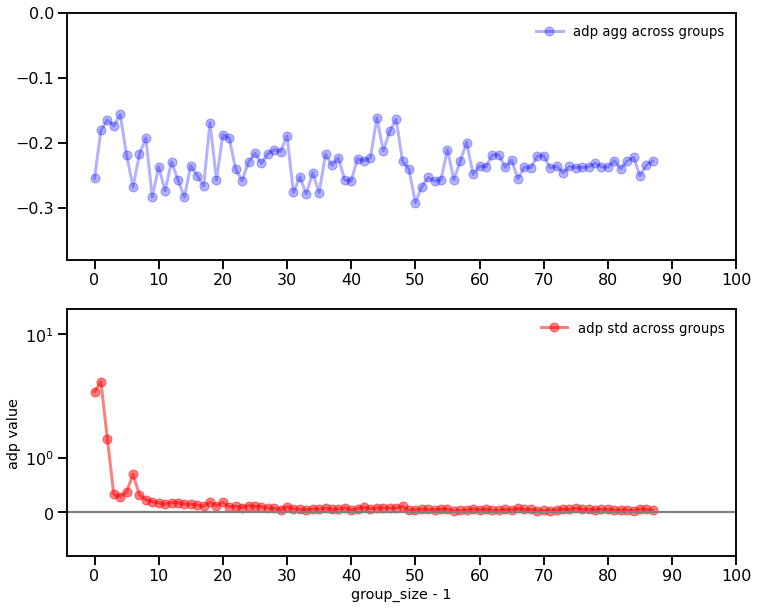

In [32]:
plt.figure(figsize=(12, 10))
plt.subplot(2,1,1)
plt.plot(adp_agg, 'o-', color='b', linewidth=3, alpha=0.3, label='adp agg across groups')
plt.xticks(np.arange(0,110,10))
plt.yticks(np.arange(-0.3, 0.01, 0.1))
plt.ylim(-0.38, 0)
plt.legend(frameon=False);

plt.subplot(2,1,2)
plt.plot(adp_std, 'o-', color='r', linewidth=3, alpha=0.5, label='adp std across groups')
plt.axhline(0, color='gray')
plt.xticks(np.arange(0,110,10))
plt.xlabel('group_size - 1')
plt.ylim(-0.8, 18)
plt.ylabel('adp value')
plt.gca().set_yscale('symlog')
plt.legend(frameon=False);

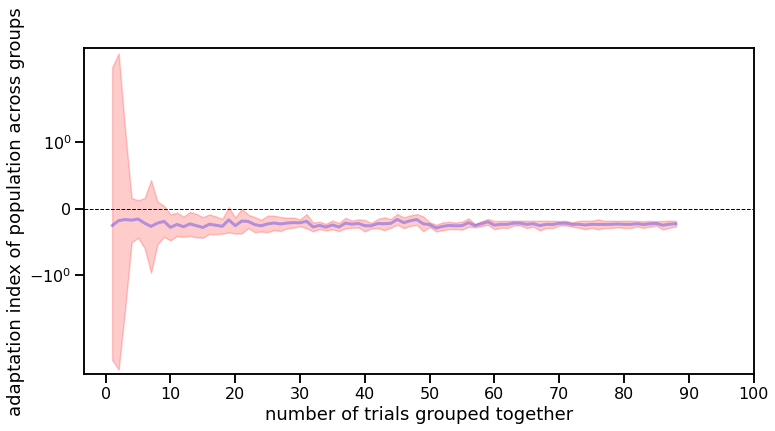

In [20]:
errbar = adp_std # adp_sem 
x = np.arange(1, adp_agg.shape[0]+1)

fig = plt.figure(figsize=(12, 6))
plt.plot(x, adp_agg, '-', color='b', linewidth=3, alpha=0.3)
plt.fill_between(x, 
                 adp_agg + errbar, adp_agg - errbar, 
                 color='r', alpha=0.2)
plt.axhline(0, color='k', linewidth=1, linestyle='--')

plt.xticks(np.arange(0,110,10))
plt.xlabel('number of trials grouped together', fontsize=18)
plt.gca().set_yscale('symlog')
plt.ylabel('adaptation index of population across groups', fontsize=18); #  across groups of different sizes

## single cell adp stability
single cells need 20-30 trials to get a stable adaptation value  

In [21]:
mean_or_median = np.median # for single cell, median is better than mean too

ncell = trace_by_trial.shape[0]
ngroup_min = 2
nsize = len(np.arange(1, trace_by_trial.shape[1] // ngroup_min)) # how many group_size to test
adp_cell_agg = np.zeros((ncell, nsize))
adp_cell_std = np.zeros((ncell, nsize))
adp_cell_sem = np.zeros((ncell, nsize))

for icell in np.arange(ncell):
    resp_ad_cell = resp_ad[icell, :]
    resp_tg_cell = resp_tg[icell, :]

    # shuffle resp_ad_pop and resp_tg_pop the same way
    np.random.seed(42)
    idx = np.random.permutation(resp_ad_pop.shape[0])
    resp_ad_cell_shuf = resp_ad_cell[idx]
    resp_tg_cell_shuf = resp_tg_cell[idx]

    for isize, group_size in enumerate(np.arange(1, trace_by_trial.shape[1] // ngroup_min)):
        ngroup = trace_by_trial.shape[1] // group_size

        resp_ad_cut = resp_ad_cell_shuf[:group_size*ngroup].reshape(ngroup, group_size)
        resp_tg_cut = resp_tg_cell_shuf[:group_size*ngroup].reshape(ngroup, group_size)
        resp_ad_group = np.sum(resp_ad_cut, axis=1)
        resp_tg_group = np.sum(resp_tg_cut, axis=1)

        adp_group = (resp_tg_group - resp_ad_group) / (resp_ad_group + 1e-7)
        adp_group_agg = mean_or_median(adp_group)
        adp_group_std = np.std(adp_group)
        adp_group_sem = adp_group_std / np.sqrt(adp_group.shape[0])
        adp_cell_agg[icell, isize] = adp_group_agg
        adp_cell_std[icell, isize] = adp_group_std
        adp_cell_sem[icell, isize] = adp_group_sem

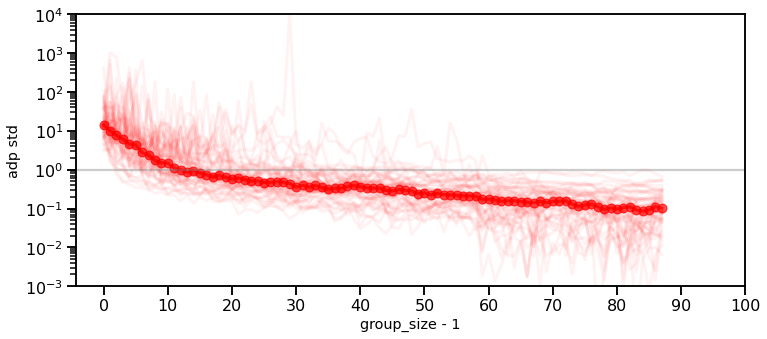

In [33]:
adp_cell_std_agg = mean_or_median(adp_cell_std, axis=0)

plt.figure(figsize=(12, 5))
plt.plot(adp_cell_std_agg, 'o-', color='r', linewidth=3, alpha=0.7, label='adp std across groups, agg over cells')
for icell in np.arange(ncell):
    plt.plot(adp_cell_std[icell, :], '-', color='r', linewidth=3, alpha=0.05, label='adp std across groups')

plt.axhline(1, alpha=0.4, color='gray')
plt.xticks(np.arange(0,110,10))
plt.xlabel('group_size - 1')

# plt.ylim(1e-3, plt.ylim()[1]) # set y axis lower limit
plt.ylim(1e-3, 1e4)
plt.yscale('log')
plt.ylabel('adp std');

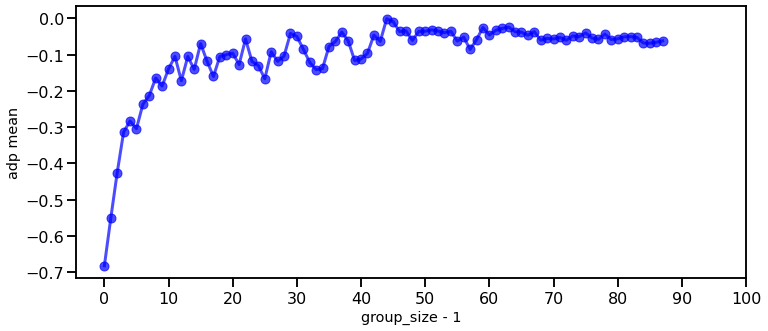

In [23]:
adp_cell_agg_agg = mean_or_median(adp_cell_agg, axis=0)

plt.figure(figsize=(12, 5))
plt.plot(adp_cell_agg_agg, 'o-', color='b', linewidth=3, alpha=0.7, label='adp agg across groups, agg over cells')
# for icell in np.arange(ncell):
#     plt.plot(adp_cell_agg[icell, :], '-', color='b', linewidth=3, alpha=0.05, label='adp agg across groups')

plt.xticks(np.arange(0,110,10))
plt.xlabel('group_size - 1')

# plt.yscale('symlog') # plot negative values on -log scale, plot ~0 values linearly: https://stackoverflow.com/questions/3305865/what-is-the-difference-between-log-and-symlog
# plt.ylim(-0.5,1)
plt.ylabel('adp mean');

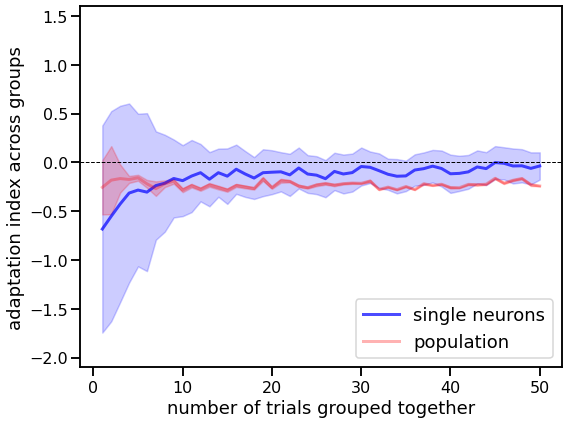

<Figure size 432x288 with 0 Axes>

In [35]:
adp_cell_sem_agg = mean_or_median(adp_cell_sem, axis=0) # adp error between groups -> agg across cells
errbar = adp_cell_sem_agg
x = np.arange(1, adp_agg.shape[0]+1)
xlim = 50

fig = plt.figure(figsize=(8, 6))
plt.plot(x[:xlim], adp_cell_agg_agg[:xlim], '-', color='blue', linewidth=3, alpha=0.7, label='single neurons')
plt.fill_between(x[:xlim],  
                adp_cell_agg_agg[:xlim] + errbar[:xlim], adp_cell_agg_agg[:xlim] - errbar[:xlim], color='b', alpha=0.2)

errbar = adp_sem 
# x = np.arange(1, adp_agg.shape[0]+1)
plt.plot(x[:xlim], adp_agg[:xlim], '-', color='red', linewidth=3, alpha=0.3, label='population')
plt.fill_between(x[:xlim], 
                 adp_agg[:xlim] + errbar[:xlim], adp_agg[:xlim] - errbar[:xlim], 
                 color='r', alpha=0.2)

plt.axhline(0, color='k', linewidth=1, linestyle='--')

plt.xticks(np.arange(0, xlim+1, 10))
plt.xlabel('number of trials grouped together', fontsize=18)
plt.ylim(-2.1, 1.6)
plt.ylabel('adaptation index across groups', fontsize=18)
plt.legend(fontsize=18, loc='lower right');

plt.tight_layout()
plt.show()
plt.draw()
# figpath = r'C:\Users\ll357\Documents\inter\results\poster 2022/'.replace('\\', '/')
# fig.savefig(os.path.join(figpath, 'adp_stability_group_trials.pdf'), format='pdf')